In [4]:
from sim_beamline import *

gas_dosing ready
reactor_cell ready
gas_analysis ready




Transient Scan ID: 2     Time: 2024-04-23 23:16:55
Persistent Unique Scan ID: '671a862b-598d-4737-9373-4fd4cea50bfc'
Setting the gas to N2 -> (30, 0, 0)
successfully set the gas to (30, 0, 0)
Starting to change the temperature to 35
Starting the acquire loop while temperature is changing
New stream: 'primary'
+-----------+------------+------------------------------------+------------------------------------+
|   seq_num |       time | reactor_cell-temperature_sam-value | reactor_cell-temperature_reg-value |
+-----------+------------+------------------------------------+------------------------------------+
|         1 | 23:17:07.6 |                            293.150 |                            293.150 |
|         2 | 23:17:18.0 |                            291.006 |                            289.816 |
A 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.
Pausing...


Deferred pause acknowledged. Continuing to checkpoint.


RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


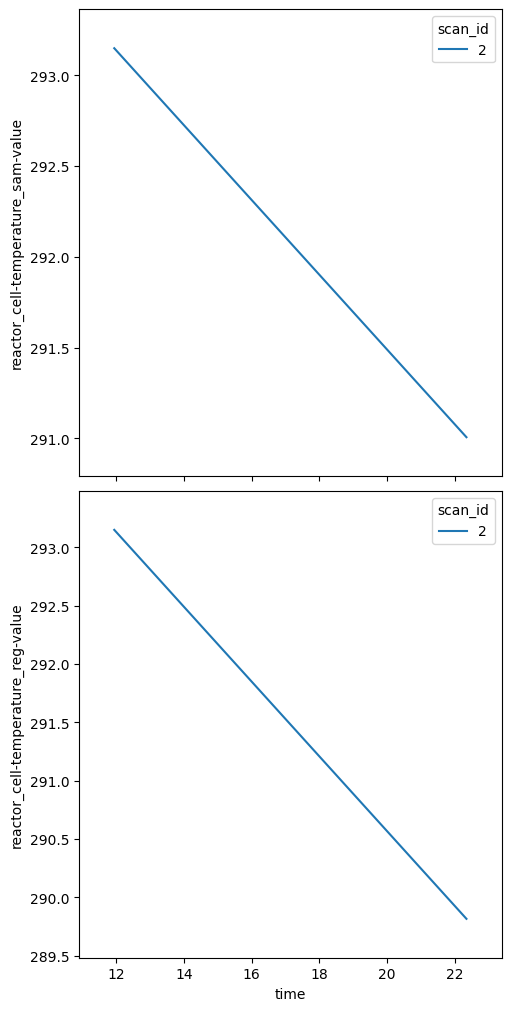

In [23]:
from bluesky.plans import scan
from bluesky.plan_stubs import sleep
from bluesky.utils import (
    separate_devices,
    all_safe_rewind,
    Msg,
    ensure_generator,
    short_uid as _short_uid,
)
import bluesky.plan_stubs as bps
from bluesky import preprocessors as bpp
import time
from ophyd.status import Status


"""
    assumed gas flows
    h = 12 ml/min
    hel = 10 ml /min
    c0 =3ml/min

    Assumed that mfc1 is H2, mfc2 is he, MFC3 is CO
"""

# Define the gas mix for a given gas selection in ml/min
gas_flows = {"N2":(30, 0,0),"Air":(0,15,0), "Ar":(0,0,5), "Off":(0,0,0)}

def set_gas(mfc_tuple):
    
    yield from bps.mv(gas_dosing.massflow_contr1, mfc_tuple[0],gas_dosing.massflow_contr2, mfc_tuple[1],gas_dosing.massflow_contr3, mfc_tuple[2], group='mfc_setting')
    yield from bps.wait(group = 'mfc_setting', timeout= 10)
    print(f"successfully set the gas to {mfc_tuple}")

def ramp(gas_sel, temp_setpoint,temp_ramp, interval=10, md = None):

    """
    This plan will set gas mfc and temperature controllers and wait for 
    the temperature to reach a required value "temp_setpoint"

    Once the temperature has been set, it will be held for "dwell" seconds
    During this time the eiger will be triggered as before 
    
    Parameters
    ------------
    gas_sel: string
        The gas to be selected ('N2', 'H2', 'CO')
    temp_setpoint : float
        temperature to be reached. Until this temperature is reached, stay in this loop
    temp_ramp : float 
        degrees/ min to ramp at. Can be positive or negative. If negative there is just no heat
    interval : int
        seconds between triggers after an acquisition has finished
    md : dict
        A dictionary of additional metadata


    """

    # Set the temperature ramp rate
    yield from bps.abs_set(reactor_cell.temperature_reg.ramp, float(temp_ramp), wait=True)    

    # Set the Gas
    print(f"Setting the gas to {gas_sel} -> {gas_flows[gas_sel]}")
    yield from set_gas(gas_flows[str(gas_sel)])

    # yield from set_abs(reactor_c.temperature_reg, temp_setpoint)
    print(f"Starting to change the temperature to {temp_setpoint}")
    complete_status = yield Msg('set', reactor_cell.temperature_reg, temp_setpoint)

    # Since we have no readback from gas analysis on actual gas env, 
    # the only thing we can do is wait for a known time
    print(f"Starting the acquire loop while temperature is changing")
    while not complete_status.done:
        
        yield from bps.one_shot([reactor_cell.temperature_reg,reactor_cell.temperature_sam]) 

        yield from bps.checkpoint()
        yield from sleep(interval)
    
    # We are actually never waiting on the gas to get anywhere
    #gas_status = Status(timeout= min_gas_time)

    # Read but don't save the temperature value
    val = yield from rd(reactor_cell.temperature_reg.value)
    print(f"Temperature Achieved: {val}C" )


def dwell(gas_sel,dwell, interval=10, md = None):

    """
    This plan will set gas mfc and wait there for a given amount of time

    During this period the eiger will be triggered 
    A delay of "interval" can be set between triggers
    
    Parameters
    ------------
    gas_sel: string
        The gas to be selected ('he', 'H2', 'CO')
    dwell : int 
        seconds to dwell at this state for
    interval : int
        seconds between triggers after an acquisition has finished
    md : dict
        A dictionary of additional metadata

    -------

    """

    # Set the Gas
    print(f"Setting the gas to {gas_sel} -> {gas_flows[gas_sel]}")
    yield from set_gas(gas_flows[str(gas_sel)])

    # Now stay here for a given amount of time
    dwell_status = Status(timeout=dwell)
    while not dwell_status.done:
        yield from bps.one_shot([reactor_cell.temperature_reg,reactor_cell.temperature_sam]) #triggers and reads everything in the detectors list
        yield from bps.checkpoint()
        yield from sleep(interval)
                

import numpy as np


def cat1():

    md = {'sample':'sample 5' , 'operator': 'HZB'}

    @bpp.run_decorator(md = md)
    def inner_plan():
        #Times all ramps by 10 and dwell divided by 60
        yield from ramp(gas_sel='N2', temp_setpoint=35, temp_ramp=20)
        yield from dwell(gas_sel='N2',dwell=1*60)

        yield from ramp(gas_sel='Air', temp_setpoint=125, temp_ramp=20)
        yield from dwell(gas_sel='Ar',dwell=1*60)

        yield from ramp(gas_sel='Ar', temp_setpoint=35, temp_ramp=20)
        yield from dwell(gas_sel='Off',dwell=1*60)
        

    return (yield from inner_plan())

RE(cat1())

In [24]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...


+-----------+------------+------------------------------------+------------------------------------+
generator cat1 ['671a862b'] (scan num: 2)



[E 23:17:39.709      run_engine: 1678] Run aborted
    Traceback (most recent call last):
      File "/home/bluesky/workshop/.venv/lib/python3.10/site-packages/bluesky/run_engine.py", line 1547, in _run
        msg = self._plan_stack[-1].send(resp)
      File "/tmp/ipykernel_1356627/905802931.py", line 143, in cat1
        return (yield from inner_plan())
      File "/home/bluesky/workshop/.venv/lib/python3.10/site-packages/bluesky/utils/__init__.py", line 1203, in dec_inner
        return (yield from plan)
      File "/home/bluesky/workshop/.venv/lib/python3.10/site-packages/bluesky/preprocessors.py", line 351, in run_wrapper
        yield from contingency_wrapper(plan,
      File "/home/bluesky/workshop/.venv/lib/python3.10/site-packages/bluesky/preprocessors.py", line 606, in contingency_wrapper
        ret = yield from plan
      File "/t

RunEngineResult(run_start_uids=('671a862b-598d-4737-9373-4fd4cea50bfc',), plan_result=<object object at 0x7f05fc63a500>, exit_status='abort', interrupted=True, reason='', exception=RequestAbort())